       n  Experimental_ns     Theory  Scaled_Theory
      10      1166.015863   5.301898    2295.061547
     100      8834.002074  21.207592    9180.246187
    1000     16125.035472  47.717083   20655.553921
   10000     30459.021218  84.830370   36720.984748
  100000     55915.967096 132.547453   57376.538669
 1000000     82249.986008 190.868332   82622.215684
10000000    112458.015792 259.793007  112458.015792

Single-point normalization constant C = 4.328755e+02
Saved CSV -> experimental_vs_theory_ns.csv
Saved plots -> plot_exp_vs_theory_ns.png, plot_straight_line.png


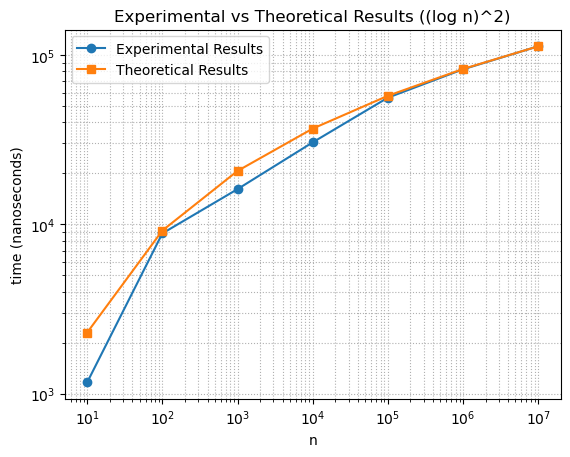

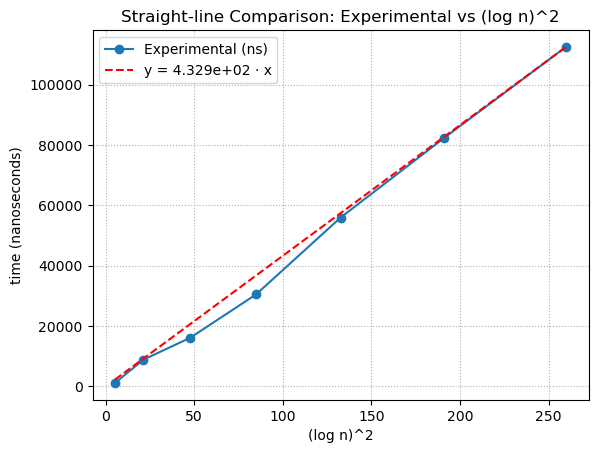

In [32]:
from math import sqrt, log
import time
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Config
# -----------------------------
# Define the input sizes we want to test.
# Powers of 10 from 10^1 to 10^7 cover small to large scales.
N_VALUES = [10**k for k in range(1, 8)]  # 10, 100, ..., 1_000_000

# -----------------------------
# Preallocate one big array set
# -----------------------------
# We create fixed arrays A and B once, with the maximum size needed.
# This avoids re-allocating memory for each test, and keeps inputs consistent.
n_max = max(N_VALUES)
A = [5] * n_max   # Example array: all entries are 5
B = [2] * n_max   # Example array: all entries are 2

# -----------------------------
# Core algorithm
# -----------------------------
def sum_products(a, b, n):
    """
    Implements the pseudocode with two nested while-loops.
    Outer loop: j starts at 5, multiplied by sqrt(3) each time.
    Inner loop: k starts at 5, multiplied by sqrt(2) each time.
    Each step adds a[j] * b[k] to the running total.
    """
    total = 0.0
    j = 5
    while j < n / 2:
        k = 5
        while k < n:
            total += a[j] * b[k]
            k = int(k * sqrt(2))   # advance k geometrically
        j = int(j * sqrt(3))       # advance j geometrically
    return total

# -----------------------------
# Timing (nanoseconds)
# -----------------------------
def time_once(n):
    """
    Run the algorithm once on arrays of size n
    and measure the execution time in nanoseconds.
    """
    t0 = time.perf_counter()
    _ = sum_products(A, B, n)  # Run algorithm; discard result (we only need time)
    t1 = time.perf_counter()
    return (t1 - t0) * 1e9     # Convert seconds → nanoseconds

# -----------------------------
# Run experiments
# -----------------------------
def run_experiments(n_values):
    """
    Run timing experiments for each n in n_values.
    Store both experimental runtimes (ns) and the theoretical value (log n)^2.
    """
    rows = []
    for n in n_values:
        exp_ns = time_once(n)
        theo   = (log(n))**2   # theoretical growth function
        rows.append({"n": n, "Experimental_ns": exp_ns, "Theory": theo})
    return pd.DataFrame(rows)

# -----------------------------
# Single-point normalization (largest n)
# -----------------------------
def normalize_single_point(df):
    """
    Normalize theoretical values by a constant factor C.
    C is chosen so that the theoretical curve matches
    the experimental result at the largest n.
    """
    idx_max = df["n"].idxmax()               # find row for largest n
    y_max   = df.loc[idx_max, "Experimental_ns"]  # experimental at largest n
    f_max   = df.loc[idx_max, "Theory"]           # theoretical at largest n
    C = y_max / f_max                        # scaling constant
    df["Scaled_Theory"] = C * df["Theory"]   # apply scaling
    return df, C

# -----------------------------
# Plots
# -----------------------------
def make_plots(df, C):
    """
    Generate and save two plots:
    1. Experimental vs Theoretical (log-log scale).
    2. Straight-line check: Experimental vs (log n)^2.
    """
    # Plot 1: log–log vs n
    plt.figure()
    plt.plot(df["n"], df["Experimental_ns"], "o-", label="Experimental Results")   
    plt.plot(df["n"], df["Scaled_Theory"], "s-", label="Theoretical Results")     
    plt.xscale("log"); plt.yscale("log")
    plt.xlabel("n"); plt.ylabel("time (nanoseconds)")
    plt.title("Experimental vs Theoretical Results ((log n)^2)")
    plt.grid(True, which="both", ls=":")
    plt.legend()
    p1 = "plot_exp_vs_theory_ns.png"
    plt.savefig(p1, bbox_inches="tight")

    # Plot 2: straight-line check — Experimental vs (log n)^2
    x = df["Theory"].to_list()
    y = df["Experimental_ns"].to_list()
    x_min, x_max = min(x), max(x)

    plt.figure()
    plt.plot(x, y, "o-", label="Experimental (ns)")   
    plt.plot([x_min, x_max], [C * x_min, C * x_max], "r--", label=f"y = {C:.3e} · x")
    plt.xlabel("(log n)^2")
    plt.ylabel("time (nanoseconds)")
    plt.title("Straight-line Comparison: Experimental vs (log n)^2")
    plt.grid(True, ls=":")
    plt.legend()
    p2 = "plot_straight_line.png"
    plt.savefig(p2, bbox_inches="tight")

    return p1, p2

# -----------------------------
# Main
# -----------------------------
def main():
    # Run experiments on all n values
    df = run_experiments(N_VALUES)

    # Apply normalization to compare theory and experiment
    df, C = normalize_single_point(df)

    # Save results to CSV
    csv_path = "experimental_vs_theory_ns.csv"
    df.to_csv(csv_path, index=False)

    # Generate plots
    p1, p2 = make_plots(df, C)

    # Print results and constant
    print(df.to_string(index=False))
    print(f"\nSingle-point normalization constant C = {C:.6e}")
    print(f"Saved CSV -> {csv_path}")
    print(f"Saved plots -> {p1}, {p2}")

if __name__ == "__main__":
    main()
